In [6]:
import torch

from communication_system import *
from deep_receiver import *
import matplotlib.pyplot as plt
from commpy.modulation import PSKModem
import pickle
import os

In [7]:
# some data about this experiment and the models' parameters
model_file = "model/additional_noise_deep_set.data"
outcome_file = "outcome/additional_noise_deep_set.data"
retrain = True

moder = {
    "bpsk": PSKModem(2),
    "qpsk": PSKModem(4)
}

ham74 = Hamming74()

class DeepSet:
    def __init__(self, mod_name, noise):
        self.mod = moder[mod_name]
        self.mod_name = mod_name
        self.noise = noise
        self.net = Conv_DenseNet_1D(32)
        self.train_ebr_log = None

class TestLog:
    def __init__(self, mod_name, noise):
        self.mod_symbol_bits = moder[mod_name].num_bits_symbol
        self.mod_name = mod_name
        self.noise = noise
        self.new_model_ebr_log = []
        self.old_model_ebr_log = []

In [8]:
# models training
# generate training dataset 
train_set_sample_num =  200 * 1000 * 9
data_bits = gen_rand_code(32, train_set_sample_num)
deep_set = None


# train the model or load the model from the files.
if not os.path.exists(model_file) or retrain:
    print("need to train nets")
    deep_set = [
        DeepSet("bpsk", 'awgn'),
        # DeepSet("qpsk",'awgn'),
        # DeepSet("bpsk", 'aggn'),
        # DeepSet("qpsk", 'aggn')
    ]
    
    
    coded_data_bits = ham74.encode(data_bits)
    EbN0 = np.arange(9)
    for setting in deep_set:
        # initialize the model
        setting.net.init()
        
        # modulate
        mod_data, _, _ = modulate(coded_data_bits, setting.mod, True)
        
        # generate noise
        SNR = EbN02SNR(EbN0, setting.mod.num_bits_symbol, 8)
        
        # generate training set
        noised_data = []
        for mod_data_part, snr in zip(mod_data.reshape([9, len(mod_data)//9, -1]), SNR):
            noised_data.append(add_noise(mod_data_part, setting.noise, snr))
        noised_data = np.concatenate(noised_data, 0)
        train_set = (noised_data, data_bits)
        
        # trian the model
        print(f"net(modulate:{setting.mod_name}, noise:{setting.noise}) start training")
        setting.train_ebr_log = train(
            net = setting.net,
            data_set = train_set,
            batch_size = 256,
            lr = 0.01,
            lr_gain = 0.5,
            epochs = 10,
            steady_epochs = 2,
            momentum = 0.9
        )
        print(f"net(modulate:{setting.mod_name}, noise:{setting.noise}) training done")
        
    # store the parameter of the trained model. 
    print(f"save the data to the file:{model_file}")
    fp = open(model_file, "wb+")
    pickle.dump(deep_set, fp)
    fp.close()
else:
    print(f"load the net param from the file:{model_file}")
    fp = open(model_file, "rb")
    deep_set = pickle.load(fp)
    fp.close()


need to train nets
net(modulate:bpsk, noise:awgn) start training
epoch1,ebr:0.4998229146003723
epoch2,ebr:0.49961283802986145
epoch3,ebr:0.49961283802986145
epoch4,ebr:0.49961283802986145
epoch5,ebr:0.49941667914390564
epoch6,ebr:0.4988940954208374
epoch7,ebr:0.4987829923629761


KeyboardInterrupt: 

In [4]:
# models are ready, then test them
snr_ticks = 19

test_set_sample_num =  200 * 1000 * snr_ticks
data_bits = gen_rand_code(32, test_set_sample_num)

coded_data_bits = ham74.encode(data_bits)
EbN0 = np.linspace(0, 8, snr_ticks)

test_logs = []

for setting in deep_set:
    mod_data, _, _ = modulate(coded_data_bits, setting.mod, True)

    # generate noise
    SNR = EbN02SNR(EbN0, setting.mod.num_bits_symbol, 8)

    # generate testing dataset for every SNR and test the model respectively
    test_log = TestLog(setting.mod_name, setting.noise)
    data_bits_per_snr = data_bits.reshape([len(SNR), len(data_bits)//len(SNR), -1])
    mod_data_per_snr = mod_data.reshape([len(SNR), len(mod_data)//len(SNR), -1])
    for data_bits_part, mod_data_part, snr in zip(data_bits_per_snr, mod_data_per_snr, SNR):
        noised_data = add_noise(mod_data_part, setting.noise, snr)
        test_set = (noised_data, data_bits_part)
        # test the deep_receiver
        print(data_bits_part.shape, mod_data_part.shape)
        deep_net_ebr = run_epoch(setting.net, test_set, 1024)
        test_log.new_model_ebr_log.append(deep_net_ebr)
        # test the traditional receiver
        out_put_data = old_receiver(noised_data, setting.mod, ham74)
        old_model_ebr = (out_put_data != data_bits_part).mean()
        test_log.old_model_ebr_log.append(old_model_ebr)
    test_logs.append(test_log)
    


(2000, 32) (2000, 448)
(2000, 32) (2000, 448)
(2000, 32) (2000, 448)
(2000, 32) (2000, 448)
(2000, 32) (2000, 448)
(2000, 32) (2000, 448)
(2000, 32) (2000, 448)
(2000, 32) (2000, 448)
(2000, 32) (2000, 448)
(2000, 32) (2000, 448)
(2000, 32) (2000, 448)
(2000, 32) (2000, 448)
(2000, 32) (2000, 448)
(2000, 32) (2000, 448)
(2000, 32) (2000, 448)
(2000, 32) (2000, 448)
(2000, 32) (2000, 448)
(2000, 32) (2000, 448)
(2000, 32) (2000, 448)


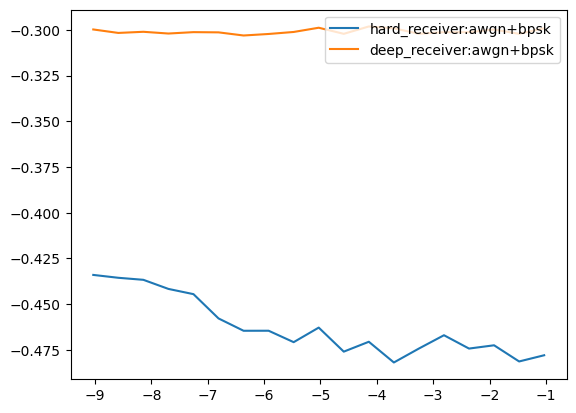

In [5]:
# the outcome of these testings

for test_log in test_logs:
    SNR = EbN02SNR(EbN0, test_log.mod_symbol_bits, 8)
    plt.plot(
        SNR, 
        np.log10(test_log.old_model_ebr_log),
        label=f"hard_receiver:{test_log.noise}+{test_log.mod_name}"
    )
    plt.plot(
        SNR, 
        np.log10(test_log.new_model_ebr_log), 
        label=f"deep_receiver:{test_log.noise}+{test_log.mod_name}"
    )
plt.legend(loc="upper right")
